In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator
import os
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from datetime import date
print(date.today())
# conda install mkl-service mkl
import mkl

2025-12-09


In [2]:
workdir = '/mnt/disk7t/xwj/axolotl_rev'
os.system(f'mkdir -p {workdir}/result/table')
os.system(f'mkdir -p {workdir}/result/figure')
os.system(f'mkdir -p {workdir}/result/gtex_processed')

# inputfiles: 
# file = f'{workdir}/gtex_nmd_AJHG2021/1-s2.0-S0002929721002329-mmc4.xlsx'
# file = f"{workdir}/gtex/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz"

# gtex/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt

0

In [ ]:
# NMD rare variants for GTEx tissues
file = f'{workdir}/gtex_nmd_AJHG2021/1-s2.0-S0002929721002329-mmc4.xlsx'
df = pd.read_excel(file, sheet_name='SupplementaryTable1', header=0, index_col=0)

In [12]:
take = ['VARIANT_ID','SAMPLE_ID','SUBJECT_ID','TISSUE_ID','Gene', 'SYMBOL']
# population frequency < 0.01, stop_gained genes
nmd = df[ df['MAX_AF'].replace('-',0) < 0.01].reset_index()\
    .query('(VARIANT_ANNOTATION == "stop_gained")').loc[:, take].drop_duplicates(ignore_index=True)

In [13]:
# eOutlier is RNA-seq based expression outlier, use z_threshold
file=f'{workdir}/gtex/gtexV8.eOutlier.stats.globalOutliers.removed.txt.gz'
eout = pd.read_csv(file, sep="\t", skiprows=0, index_col=0)
eout.index = [x.split('.')[0] for x in eout.index ]
# nmd table overlap with eout stats. write eout value as last column of nmd
i = 0
vec = []
for idx, row in nmd.iterrows():
    sample, gene, symbol = row['SUBJECT_ID'], row['Gene'],row['SYMBOL']
    if (gene in eout.index) & (sample in eout.columns):
        vec.append(eout.loc[gene, sample])
    else: #  'not find'
        vec.append(np.nan)
        i = i+1
    # print(sample, gene, symbol)
print(i)
nmd['eout'] = vec
nmd

1331


,VARIANT_ID,SAMPLE_ID,SUBJECT_ID,TISSUE_ID,Gene,SYMBOL,eout
0,chr1_946463_G_T_b38,GTEX-YFC4-0006-SM-4RGLV,GTEX-YFC4,WHLBLD,ENSG00000188976,NOC2L,-4.09
1,chr1_946463_G_T_b38,GTEX-YFC4-0008-SM-4RGM3,GTEX-YFC4,FIBRBLS,ENSG00000188976,NOC2L,-4.09
2,chr1_946463_G_T_b38,GTEX-YFC4-0011-R10a-SM-4SOK5,GTEX-YFC4,BRNCTXB,ENSG00000188976,NOC2L,-4.09
3,chr1_946463_G_T_b38,GTEX-YFC4-0011-R11a-SM-4SOK6,GTEX-YFC4,BRNCHB,ENSG00000188976,NOC2L,-4.09
4,chr1_946463_G_T_b38,GTEX-YFC4-0011-R1a-SM-4V6EH,GTEX-YFC4,BRNHPP,ENSG00000188976,NOC2L,-4.09
...,...,...,...,...,...,...,...
28713,chr9_137497207_G_A_b38,GTEX-X585-0011-R4B-SM-46MVH,GTEX-X585,BRNAMY,ENSG00000130653,PNPLA7,-0.43
28714,chr9_137497207_G_A_b38,GTEX-X585-0011-R10A-SM-46MUY,GTEX-X585,BRNCTXB,ENSG00000130653,PNPLA7,-0.43
28715,chr9_137497207_G_A_b38,GTEX-X585-0011-R2B-SM-46MVF,GTEX-X585,BRNSNG,ENSG00000130653,PNPLA7,-0.43
28716,chr9_137497207_G_A_b38,GTEX-X585-0011-R3B-SM-46MVG,GTEX-X585,BRNACC,ENSG00000130653,PNPLA7,-0.43


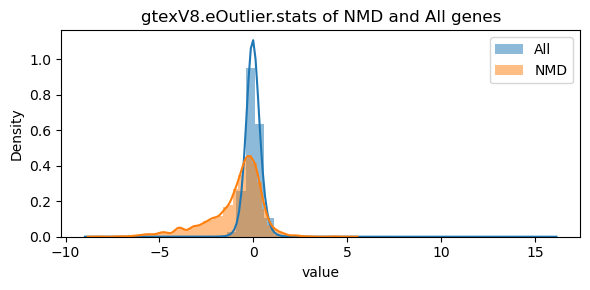

In [ ]:
## NMD enrich expression outliers？
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6, 3))

sns.histplot(data=eout.stack(), bins=50, alpha=0.5,linewidth=0, label='All', stat='density')
sns.histplot(data=nmd['eout'], bins=50, alpha=0.5,linewidth=0, label='NMD', stat='density')

sns.kdeplot(data=eout.stack(), alpha=1)
sns.kdeplot(data=nmd['eout'], alpha=1)

plt.title('gtexV8.eOutlier.stats of NMD and All genes')
plt.xlabel('value')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/gtex_dist_eout_nmd_vs_background.pdf', dpi=200)

In [ ]:
# GTEx RNA-seq read counts
file = f"{workdir}/gtex/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz"
# gtex = pd.read_csv(file, sep="\t", skiprows=2, index_col=0)
parquet_file = f'{file}.parquet'  # replace to Parquet
gtex = pd.read_parquet(parquet_file)

gtex.index = [x.split('.')[0] for x in gtex.index ]
gtex_symbol = gtex['Description'].copy() # gene symbol backup
gtex = gtex.drop(columns=['Description'])

# GTEx nmd & reads overlap，find nmd gene expression value，write to nmd
# time: 70 s
# RIN filter removed samples, therefore not all NMD are found in reads.gct
# use gene & sample to locate GTEx value
s_col, g_col = 'SAMPLE_ID','Gene'

i = 0
vec = []
for idx, row in nmd.iterrows():
    sample, gene, symbol = row['SAMPLE_ID'], row['Gene'],row['SYMBOL']#(sample, gene, symbol)
    if (gene in gtex.index) & (sample in gtex.columns):
        vec.append(gtex.loc[gene, sample])
        # print(sample, gene, symbol)
    else: #  'not find'
        vec.append(np.nan)
        # print(sample, gene, symbol)
        i = i+1
    # print(sample, gene, symbol)
print(i)
nmd['gene_reads'] = vec
nmd = nmd.query('gene_reads.notnull()')

0


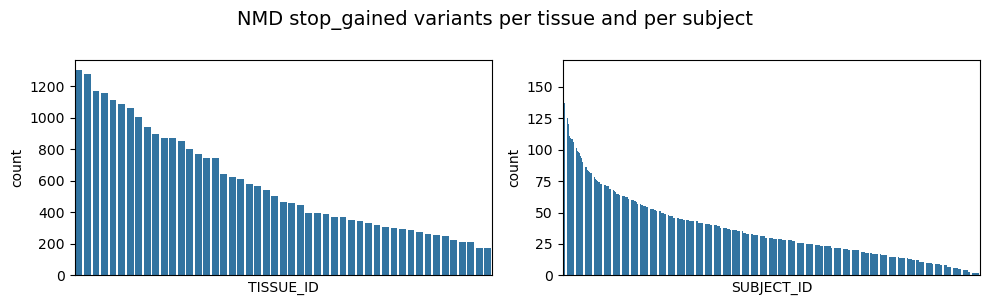

In [31]:
# nmd = pd.read_csv(f'{workdir}/gtex_nmd_AJHG2021/nmd_rare_stop_gained_with_reads.tsv', sep='\t')
# sns.heatmap( nmd.groupby(['TISSUE_ID','SUBJECT_ID']).size().unstack() )
# sns.histplot(, bins=50, alpha=0.5,linewidth=0)
plt.style.use('default')
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))
sns.barplot( nmd['TISSUE_ID'].value_counts(), linewidth=0, ax=ax[0])
sns.barplot( nmd['SUBJECT_ID'].value_counts(), linewidth=0, ax=ax[1])
# remove x tick labels
ax[0].set_xticks([])
ax[0].set_xticklabels([])
ax[1].set_xticks([])
ax[1].set_xticklabels([])
fig.suptitle('NMD stop_gained variants per tissue and per subject', y=1, fontsize=14,)
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/gtex_count_nmd_per_tissue_per_sample.pdf', dpi=200)

In [ ]:
# save updated nmd table
nmd.to_csv(f'{workdir}/gtex_nmd_AJHG2021/nmd_rare_stop_gained_with_reads.tsv',sep='\t', index=False)
if False:
    nmd = pd.read_csv(f'{workdir}/gtex_nmd_AJHG2021/nmd_rare_stop_gained_with_reads.tsv', sep='\t')
print( 'number of NMD genes per tissue:\n', nmd.groupby('TISSUE_ID').size().describe()) 
print( 'number of NMD genes per individual:\n',nmd.groupby('SUBJECT_ID').size().describe())
print( 'number of genes total:', nmd['SYMBOL'].nunique())

In [ ]:
# Supplemental Table output
nmd.to_excel(f'{workdir}/result/table/s1_nmd_rare_stop_gained.xlsx', sheet_name='s1_gtex_nmd',index=True)

In [ ]:
# tissues have long and short names
# use long tissue_name to get gtex samples; use short tissue_id to get NMD outliers 
file = f"{workdir}/gtex/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"
meta_3cols = pd.read_csv(file, sep="\t", skiprows=0, 
                        usecols = ['SAMPID', 'SMTS',  'SMTSD', ],)
tissue_name_mapping = nmd.drop_duplicates(subset='TISSUE_ID')\
    .loc[:, ['SAMPLE_ID','TISSUE_ID']].sort_values(by='TISSUE_ID',ignore_index=True).copy()

vec = [] 
for idx, row in tissue_name_mapping.iterrows():
    s = row['SAMPLE_ID']
    tissue_name_long = meta_3cols.query('SAMPID == @s')['SMTSD'].values
    vec.extend(tissue_name_long)
del meta_3cols
tissue_name_mapping['TISSUE_NAME'] = vec
tissue_name_mapping.head()

,SAMPLE_ID,TISSUE_ID,TISSUE_NAME
0,GTEX-YFC4-0226-SM-57WD2,ADPSBQ,Adipose - Subcutaneous
1,GTEX-1IDJC-0226-SM-CMKG2,ADPVSC,Adipose - Visceral (Omentum)
2,GTEX-144GL-1826-SM-79OMB,ADRNLG,Adrenal Gland
3,GTEX-YFC4-0326-SM-4TT3U,ARTAORT,Artery - Aorta
4,GTEX-YFC4-0726-SM-62LF6,ARTCRN,Artery - Coronary


In [ ]:

tissues = pd.DataFrame(
    index = tissue_name_mapping.index,
    columns = ['TISSUE_ID','TISSUE_NAME','N_SAMPLE','N_GENE','CTS_FILE', 'OUTLIER_FILE',])

# 各组织cts表达矩阵和outlier
for idx, row in (tissue_name_mapping.iterrows()):
    tissue_id, tissue_name = row['TISSUE_ID'],  row['TISSUE_NAME']
    
    # (1) cts: expression matrix
    # keep stable expressed genes
    min_reads = 10
    tissue_sampid = all_meta.loc[ (all_meta.SMTSD == tissue_name), 'SAMPID']
    tissue_gtex = gtex.loc[:, tissue_sampid].copy()
    cts = tissue_gtex[ (tissue_gtex > min_reads).all(axis=1) ].copy()
    cts.index.name, cts.columns.name = 'Gene', 'Sample'
    ctsfile = f'{workdir}/gtex_processed/cts_{tissue_id}_s{cts.shape[1]}_g{cts.shape[0]}.tsv.gz'
    cts.to_csv(ctsfile, sep='\t')
            
    # (2) outlier: true outlier gene-sample pair in cts.
    outlier = nmd.query('(TISSUE_ID == @tissue_id) & \
                        (SAMPLE_ID in @cts.columns ) & \
                        (Gene in @cts.index)').copy().reset_index(drop=True)
    
    outlierfile = f'{workdir}/gtex_processed/outlier_{tissue_id}_sg{outlier.shape[0]}.tsv'
    outlier.to_csv(outlierfile, sep='\t')
    
    validation_set, test_set = train_test_split(outlier, test_size=0.2, random_state=42)

    validation_set = validation_set.reset_index(drop=True)
    test_set = test_set.reset_index(drop=True)

    validation_set.to_csv(outlierfile.replace('.tsv', '_valid.tsv'), sep='\t')
    test_set.to_csv(outlierfile.replace('.tsv', '_test.tsv'), sep='\t')
    
    # print(f'{tissue_name}/{tissue_id}/min_reads={min_reads} stable_ngene={cts.shape[0]} nsample={cts.shape[1]} noutlier={outlier.shape[0]}')
    tissues.loc[idx, :] = [ tissue_id, tissue_name, cts.shape[1], cts.shape[0],ctsfile, outlierfile]
tissues.to_csv(f'{workdir}/gtex_processed/tissues.tsv', sep='\t')

In [19]:
tissues = pd.read_csv(f'{workdir}/gtex_processed/tissues.tsv', sep='\t', index_col=0)
tissues['N_SAMPLE'].sum()

16999

## prepare config files. then detect outlier with shell script

In [ ]:
# level 1
output_path = f'{workdir}/result/dataset_gtex_nmd'
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

os.system(f'mkdir -p {samples_path} {task_config_path} {task_output_path} {metric_output_path}')

0

In [ ]:
# prepare task config file.
# task_config table have columns indicating output filenames of different methods

for i, row in tissues.iterrows():
    
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE

    prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    cols = ['Dname','cts','samples','MyMethod','OUTRIDER','ABEILLE','OUTSINGLE']
    tasks = [0] # list of parallel tasks
    task_config = pd.DataFrame(index=tasks, columns=cols)
    task_config.index.name = 'task'

    task = 0 # only one task for this tissue  
    task_config.loc[task, 'Dname' ] = t
    task_config.loc[task, 'cts' ] = ctsfile
    task_config.loc[task, 'samples' ] = f'{samples_path}/{prefix}.txt'
    # create filenames
    task_config.loc[task, 'MyMethod'] = f'{task_output_path}/{prefix}/{task:03d}_mymethod.txt.gz'
    task_config.loc[task, 'OUTRIDER'] = f'{task_output_path}/{prefix}/{task:03d}_outrider.txt.gz'
    task_config.loc[task, 'OUTSINGLE'] = f'{task_output_path}/{prefix}/{task:03d}_outsingle.txt.gz'
    task_config.loc[task, 'ABEILLE'] = f'{task_output_path}/{prefix}/{task:03d}_abeille.txt.gz'

    # 0. create config & output folder of parallel tasks
    task_config.to_csv(f'{task_config_path}/{prefix}.config',sep='\t')
    os.system(f'mkdir -p {task_output_path}/{prefix}')
    
    # 1. sample ids of parallel tasks
    cts = pd.read_csv(ctsfile, sep='\t',index_col=0)
    all_samples_df = pd.DataFrame(data=cts.columns.T.tolist()).transpose()
    all_samples_df.index = task_config.index
    all_samples_df.to_csv(f'{samples_path}/{prefix}.txt',sep='\t')

In [22]:
task_config

,Dname,cts,samples,MyMethod,OUTRIDER,ABEILLE,OUTSINGLE
task,,,,,,,
0,WHLBLD,/mnt/disk7t/xwj/axolotl_rev/gtex_processed/cts...,/mnt/disk7t/xwj/axolotl_rev/result/dataset_gte...,/mnt/disk7t/xwj/axolotl_rev/result/dataset_gte...,/mnt/disk7t/xwj/axolotl_rev/result/dataset_gte...,/mnt/disk7t/xwj/axolotl_rev/result/dataset_gte...,/mnt/disk7t/xwj/axolotl_rev/result/dataset_gte...


In [27]:
! ls {task_config_path}

continue			t25_FIBRBLS_s504_g12575.config
t00_ADPSBQ_s648_g13675.config	t26_HRTAA_s424_g13386.config
t01_ADPVSC_s531_g13728.config	t27_HRTLV_s423_g11990.config
t02_ADRNLG_s254_g14019.config	t28_KDNCTX_s73_g15406.config
t03_ARTAORT_s424_g13793.config	t29_LCL_s174_g12729.config
t04_ARTCRN_s233_g13797.config	t30_LIVER_s220_g12982.config
t05_ARTTBL_s653_g12768.config	t31_LUNG_s566_g13941.config
t06_BREAST_s447_g13813.config	t32_MSCLSK_s802_g11831.config
t07_BRNACC_s168_g15295.config	t33_NERVET_s609_g14403.config
t08_BRNAMY_s146_g14492.config	t34_OVARY_s178_g14388.config
t09_BRNCDT_s243_g14646.config	t35_PNCREAS_s321_g13469.config
t10_BRNCHA_s240_g15784.config	t36_PRSTTE_s234_g14779.config
t11_BRNCHB_s212_g15298.config	t37_PTTARY_s278_g15556.config
t12_BRNCTXA_s246_g15463.config	t38_SKINNS_s601_g14125.config
t13_BRNCTXB_s204_g15059.config	t39_SKINS_s695_g13963.config
t14_BRNHPP_s192_g14445.config	t40_SLVRYG_s161_g14804.config
t15_BRNHPT_s196_g14650.config	t41_SNTTRM_s185_g14779.config
t16_B